In [214]:
import math
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator

In [215]:
def analyse(qc, filename):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()

    total_counts = sum(counts.values())
    probs = {key: value / total_counts for key, value in counts.items()}
    fig = plot_histogram(probs, title=f"Grover result for value=")
    plt.show()
    fig.savefig(filename)

    # Optionally, print the most probable outcomes
    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
    print("Top results:")
    for k, v in list(sorted_counts.items())[:5]:
        print(f"{k} → {v} ({v / 2048:.2%})")

In [216]:
def analyse_freq(qc):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()

    total_counts = sum(counts.values())

    # Sort by decimal value for consistent ordering
    sorted_items = sorted(counts.items(), key=lambda x: int(x[0], 2))

    labels = []
    values = []
    percents = []
    freqs = {}

    for bitstring, count in sorted_items:
        val_decimal = int(bitstring, 2)
        percent = (count / total_counts) * 100
        labels.append(str(val_decimal))
        values.append(percent)
        percents.append(f"{percent:.2f}%")
        freqs[val_decimal] = f"{percent:.2f}% {bitstring}"

    # Plot histogram with percentage labels
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values)

    for bar, pct in zip(bars, percents):
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + 0.5,
            pct,
            ha="center",
            va="bottom",
        )

    plt.xlabel("Value (decimal)")
    plt.ylabel("Frequency (%)")
    plt.title("Quantum Value Frequencies")
    plt.ylim(0, max(values) + 5)
    plt.tight_layout()
    # plt.savefig("filter.png")
    plt.show()

    # Print frequency results
    print(freqs)

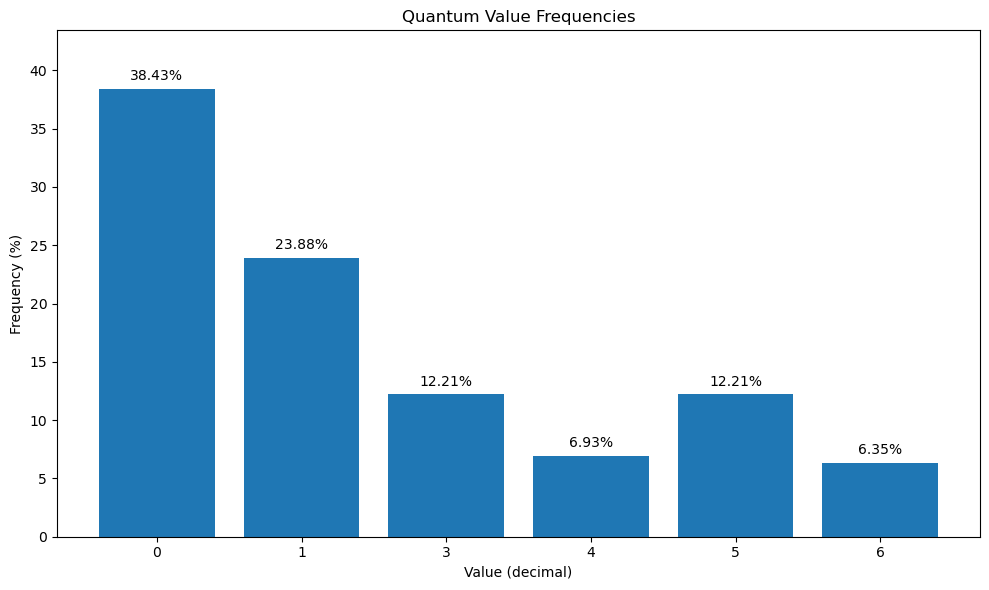

{0: '38.43% 000', 1: '23.88% 001', 3: '12.21% 011', 4: '6.93% 100', 5: '12.21% 101', 6: '6.35% 110'}


In [217]:
L = [1, 6, 5, 3, 1, 1, 3, 4, 1, 5]
n_index = math.ceil(math.log2(len(L)))  # log2(L)
n_val = math.ceil(math.log2(max(L) + 1))  # bits needed to store values (max = 4)

# Quantum circuit: index + value
qc = QuantumCircuit(n_index + n_val, n_val)

idx_qubits = list(range(n_index))
val_qubits = list(range(n_index, n_index + n_val))

# 1. Put pointer into uniform superposition
for i in idx_qubits:
    qc.h(i)

# 2. Encode only valid indices from 0 to len(L) - 1
for idx in range(2**n_index):
    if idx >= len(L):
        continue  # Skip uninitialized (placeholder) memory slots

    val = L[idx]
    idx_bin = format(idx, f"0{n_index}b")
    val_bin = format(val, f"0{n_val}b")

    # Flip index bits for control
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

    # Encode value with multi-controlled X
    for j, bit in enumerate(reversed(val_bin)):
        if bit == "1":
            qc.mcx(idx_qubits, val_qubits[j], mode="noancilla")

    # Unflip index bits
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

qc.barrier(range(n_index + n_val))

# 3. Measure only value qubits (like classical frequency)
for i in range(n_index, n_index + n_val):
    qc.measure(i, i - n_index)

qc.barrier(range(n_index + n_val))

# 4. Simulate & Convert to percentage
analyse_freq(qc)

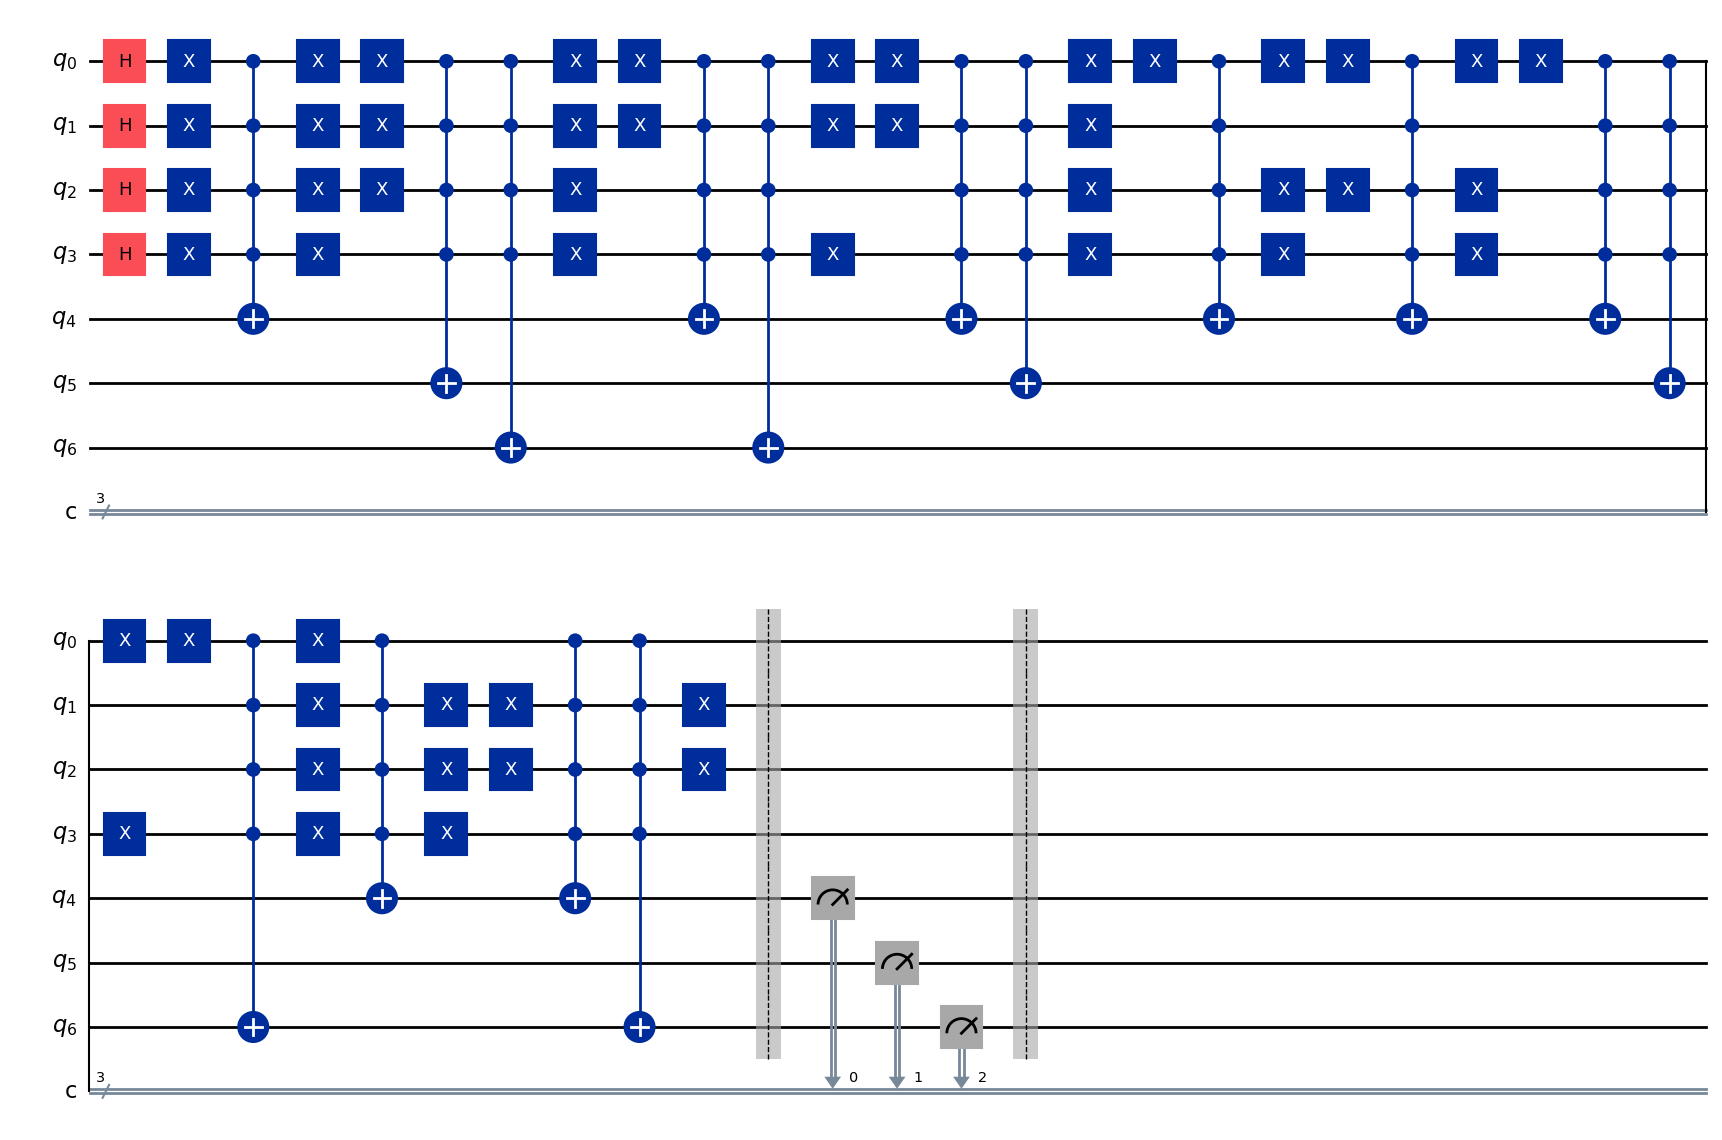

In [218]:
qc.draw(output="mpl", scale=1)

In [219]:
def build_oracle(n_index, n_val, valid_indices, target_bin):
    """
    Oracle flips the phase only when:
      - index qubits match one of the valid indices
      - AND value qubits match the target value
    """
    num_qubits = n_index + n_val
    oracle = QuantumCircuit(num_qubits)

    for idx in valid_indices:
        idx_bin = format(idx, f"0{n_index}b")

        # Apply X gates to index qubits to match `idx`
        for i, bit in enumerate(idx_bin):
            if bit == "0":
                oracle.x(i)

        # Apply X to value qubits where target_bin has 0s
        for j, bit in enumerate(reversed(target_bin)):
            if bit == "0":
                oracle.x(n_index + j)

        # Apply MCX on all qubits: index + value
        all_controls = list(range(num_qubits))
        target = all_controls[-1]
        oracle.h(target)
        oracle.mcx(all_controls[:-1], target)
        oracle.h(target)

        # Uncompute X gates (value qubits first, then index)
        for j, bit in enumerate(reversed(target_bin)):
            if bit == "0":
                oracle.x(n_index + j)
        for i, bit in enumerate(idx_bin):
            if bit == "0":
                oracle.x(i)

    return oracle

In [220]:
def run_grover_search(qc, n_index, n_val, target_value, L):
    val_qubits = list(range(n_index, n_index + n_val))
    target_bin = format(target_value, f"0{n_val}b")
    valid_indices = list(range(len(L)))  # e.g., indices 0 to 9

    oracle = build_oracle(n_index, n_val, valid_indices, target_bin)
    grover_op = GroverOperator(oracle=oracle, insert_barriers=True)

    # Compose Grover operator onto the memory-prepared circuit
    grover_qc = qc.compose(grover_op, front=False)

    # New circuit for measuring only value qubits
    measured_qc = QuantumCircuit(n_index + n_val, n_val)
    measured_qc.compose(grover_qc, inplace=True)

    # Measure only value qubits
    for i in range(n_val):
        measured_qc.measure(n_index + i, i)

    return measured_qc

Target value for Grover: 1


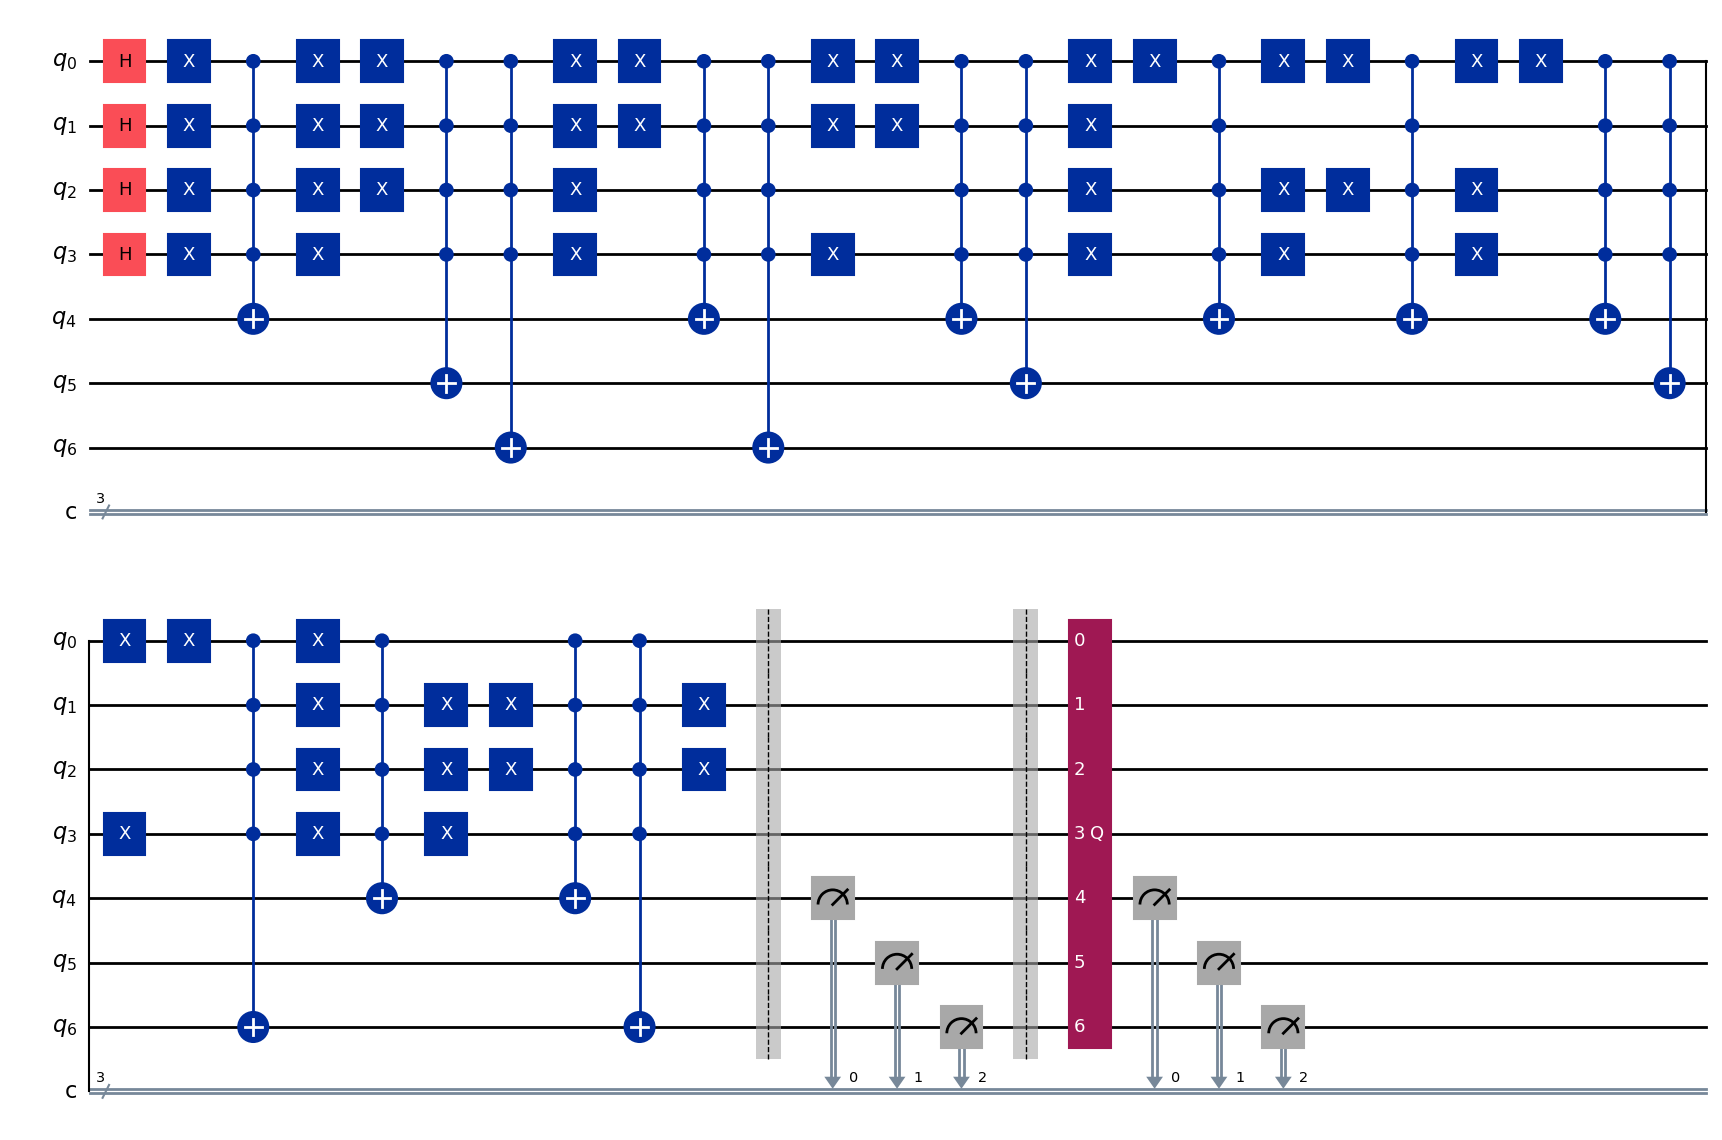

In [221]:
target_value = next(v for v in sorted(set(L)) if v > 0)
print(f"Target value for Grover: {target_value}")

grover_circuit = run_grover_search(qc, n_index, n_val, target_value, L)
grover_circuit.draw(output="mpl", scale=1)

In [222]:
# # Simulate
# grover_circuit = grover_circuit.decompose()
# backend = Aer.get_backend("qasm_simulator")
# job = backend.run(grover_circuit, shots=1024)
# counts = job.result().get_counts()

# # Display result
# from qiskit.visualization import plot_histogram

# plot_histogram(counts, title=f"Grover result for value={target_value}")
# plt.show()

analyse(grover_circuit, filename=f"grover_value_{target_value}")

Top results:
000 → 670 (32.71%)
001 → 456 (22.27%)
011 → 302 (14.75%)
101 → 279 (13.62%)
100 → 152 (7.42%)


In [223]:
# Find the second-smallest value (excluding 0)
unique_vals = sorted(set(L))
filtered_vals = [v for v in unique_vals if v != 0]

if len(filtered_vals) >= 2:
    second_min = filtered_vals[1]
    print(f"Second smallest non-zero value is: {second_min}")

    # Run Grover's search
    grover_circuit = run_grover_search(qc, n_index, n_val, second_min, L)
    analyse(grover_circuit, filename=f"grover_value_{second_min}")
else:
    print("Not enough distinct non-zero values in L.")

Second smallest non-zero value is: 3
Top results:
000 → 646 (31.54%)
001 → 470 (22.95%)
101 → 292 (14.26%)
011 → 255 (12.45%)
100 → 164 (8.01%)
